### Алгоритмы интеллектуальной обработки больших объемов данных
## Домашнее задание №4 - Градиентный бустинг


**Общая информация**

**Срок сдачи:** 10 мая 2021, 08:30   
**Штраф за опоздание:** -2 балла после 08:30 10 мая, -4 балла после 08:30 17 мая, -6 баллов после 08:30 24 мая, -8 баллов после 08:30 31 мая.

При отправлении ДЗ указывайте фамилию в названии файла Присылать ДЗ необходимо в виде ссылки на свой github репозиторий на почту ml1.sphere@mail.ru с указанием темы в следующем формате:
[ML0221, Задание 4] Фамилия Имя. 


Используйте данный Ipython Notebook при оформлении домашнего задания.

##  Считаем производные для функций потерь (1 балл)

Мы будем реализовать градиентный бустинг для 3 функций потерь:

1) MSE  $L(a(x_i), y_i) = (y_i - a(x_i)) ^ 2$

2) Экспоненциальная  $L(a(x_i), y_i) = exp( -a(x_i) y_i), y_i \in \{-1, 1\}$

3) Логистическая  $L(a(x_i), y_i) = \log (1 + exp( -a(x_i) y_i)), y_i \in \{-1, 1\}$

где $a(x_i)$ предсказание бустинга на итом объекте. 

Для каждой функции потерь напишите таргет, на который будет настраиваться каждое дерево в бустинге. 

Ваше решение тут

1) $ -\frac{\partial L}{\partial a} (a(x_i), y_i) = 2 \cdot (y_i - a(x_i))$

2) $ -\frac{\partial L}{\partial a} (a(x_i), y_i) = y_i \cdot exp(-a(x_i) y_i)$

3) $ -\frac{\partial L}{\partial a} (a(x_i), y_i) = \frac{y_i \cdot exp(-a(x_i) y_i)}{1 + exp( -a(x_i) y_i)}$

##  Реализуем градиентный бустинг (3 балла)

Реализуйте класс градиентного бустинга для классификации. Ваша реализация бустинга должна работать по точности не более чем на 5 процентов хуже чем GradientBoostingClassifier из sklearn. 


Детали реализации:

-- должно поддерживаться 3 функции потерь

-- сами базовые алгоритмы(деревья, линейные модели и тп) реализовать не надо, просто возьмите готовые из sklearn

-- в качестве функции потерь для построения одного дерева используйте MSE

-- шаг в бустинге можно не подбирать, можно брать константный

-- можно брать разные модели в качестве инициализации бустинга

-- должны поддерживаться следующие параметры:

а) число итераций
б) размер шага
в) процент случайных фичей при построении одного дерева
д) процент случайных объектов при построении одного дерева
е) параметры базового алгоритма (передавайте через **kwargs)

In [1]:
import numpy as np

from sklearn.datasets import load_wine
from sklearn.ensemble import GradientBoostingClassifier, RandomForestRegressor
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
import matplotlib.pyplot as plt

In [11]:
class MyGradientBoostingClassifier:

    def __init__(self, loss='mse', learning_rate=0.1, n_estimators=100, colsample=1, subsample=1, *args, **kwargs):
        """
        loss -- один из 3 лоссов:
        learning_rate -- шаг бустинга
        n_estimators -- число итераций
        subsample -- процент рандомных признаков при обучнеии одного алгоритма
        colsample -- процент рандомных объектов при обучнеии одного алгоритма
        args, kwargs -- параметры  базовых моделей
        """
        # Ваш код здесь
        self.loss = loss
        self.learning_rate = learning_rate
        self.n_estimators = n_estimators
        self.colsample = colsample
        self.subsample = subsample
        self.models = []
        self.args = args
        self.kwargs = kwargs
        
        def loss_MSE(ai, y):
            return np.mean(np.square(y - ai))

        def target_MSE(ai, y):
            return 2 * (y - ai)

        def loss_exp(ai, y):
            return np.mean(np.exp(- y * ai))

        def target_exp(ai, y):
            return y * np.exp(- y * ai)

        def loss_log(ai, y):
            return np.mean(np.log(1 + np.exp(- y * ai)))

        def target_log(ai, y):
            return (y * np.exp(-y * ai)) / (1 + np.exp(-y * ai)) 
        
        if self.loss == "mse":
            self.loss_f = loss_MSE
            self.target = target_MSE
        elif self.loss == "exponent":
            self.loss_f = loss_exp
            self.target = target_exp
        elif self.loss == "logit":
            self.loss_f = loss_log
            self.target = target_log
    
    def fit(self, X, y, base_model=DecisionTreeRegressor, init_model=None):
        """
        X -- объекты для обучения:
        y -- таргеты для обучения
        base_model -- класс базовых моделей, например sklearn.tree.DecisionTreeRegressor
        init_model -- класс для первой модели, если None то берем константу (только для посл задания)
        """
        # Ваш код здесь
        if init_model == None:
            model = None
        else:
            init = init_model(*self.args, **self.kwargs)
            model = init.fit(X, y)
        self.models.append((model, None))
        
        for i in range(1, self.n_estimators + 1):
            rand_obj = np.random.choice(X.shape[0], round(X.shape[0] * self.subsample), replace=False)
            rand_feat = np.random.choice(X.shape[1], round(X.shape[1] * self.colsample), replace=False)
            X_1 = X[rand_obj]
            y_1 = y[rand_obj]
            grand = self.target(self.predict(X_1), y_1)
            model = base_model(*self.args, **self.kwargs)
            model.fit(X_1[:,rand_feat], grand)
            self.models.append((model, rand_feat))
        return self
    
    def predict(self, X):
        # Ваш код здесь
        if self.models[0][0] == None:
            pred = np.zeros(X.shape[0])
        else:
            pred = self.models[0][0].predict(X)
        for m in self.models[1:]:
            pred += self.learning_rate * m[0].predict(X[:,m[1]])
        return np.rint(pred).astype(int)


In [12]:
my_clf = MyGradientBoostingClassifier()
clf = GradientBoostingClassifier()

In [13]:
wine = load_wine()
X_train, X_test, y_train, y_test = train_test_split(wine.data, wine.target, test_size=0.1, stratify=wine.target)

In [14]:
my_clf.fit(X_train, y_train)
clf.fit(X_train, y_train)
print(accuracy_score(y_pred=clf.predict(X_test), y_true=y_test))
print(accuracy_score(y_pred=my_clf.predict(X_test), y_true=y_test))

0.9444444444444444
0.9444444444444444


## Подбираем параметры (2 балла)

Давайте попробуем применить Ваш бустинг для предсказаний цены домов в Калифорнии. Чтобы можно было попробовтаь разные функции потерь, переведем по порогу таргет в 2 класса: дорогие и дешевые дома.

В задании нужно

1) Построить график точности в зависимости от числа итераций на валидации.

2) Подобрать оптимальные параметры Вашего бустинга на валидации. 


In [6]:
from sklearn.datasets import fetch_california_housing
X, y = fetch_california_housing(return_X_y=True)

In [7]:
# Превращаем регрессию в классификацию
y = (y > 2.0).astype(int)
print(X.shape, y.shape)

(20640, 8) (20640,)


In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

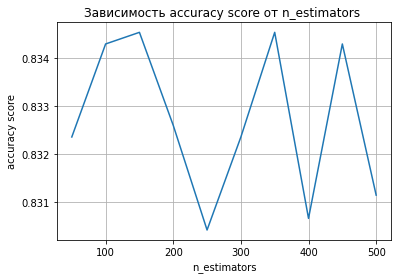

In [9]:
n_estimators = np.arange(50,501,50)
res = []

for n in n_estimators:
    my_clf = MyGradientBoostingClassifier(n_estimators = n)
    my_clf.fit(X_train, y_train)
    y_pred = my_clf.predict(X_test)
    res.append(accuracy_score(y_pred, y_test))
    
fig, ax = plt.subplots()

ax.plot(n_estimators, res)
ax.grid()

ax.set_title('Зависимость accuracy score от n_estimators ')

ax.set_xlabel('n_estimators')
ax.set_ylabel('accuracy score')

plt.show()

In [15]:
top_params = {'loss' : None, 'colsample':0, 'subsample':0, 'accuracy':0}
min_acc = 0.0
for loss in ['mse', 'exponent','logit']:
    for colsample in [0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]:
        for subsample in [0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]:
            my_clf = MyGradientBoostingClassifier(n_estimators=150, loss=loss, 
                                                  colsample=colsample, subsample=subsample)
            try:
                my_clf.fit(X_train, y_train)
                y_pred = my_clf.predict(X_test)
                acc = accuracy_score(y_pred, y_test)
            except Exception:
                print(loss, colsample, subsample)
            if min_acc < acc:
                top_params['loss'] = loss
                top_params['colsample'] = colsample
                top_params['subsample'] = subsample
                top_params['accuracy'] = acc
                min_acc = acc
top_params      

{'accuracy': 0.841327519379845,
 'colsample': 0.9,
 'loss': 'mse',
 'subsample': 1.0}

## BooBag BagBoo (1 балл)



Попробуем объединить бустинг и бэгинг. Давайте

1) в качестве базовой модели брать не дерево решений, а случайный лес (из sklearn)

2) обучать N бустингов на бустрапированной выборке, а затем предикт усреднять

Попробуйте обе этих стратегии на данных из прошлого задания. Получилось ли улучшить качество? Почему?

In [37]:
my_clf = MyGradientBoostingClassifier(loss='mse', n_estimators=150, subsample=1, colsample=0.9)
my_clf.fit(X_train, y_train, base_model=RandomForestRegressor)
y_pred = my_clf.predict(X_test)
accuracy_score(y_pred, y_test)

0.8282461240310077

In [20]:
my_clfs = []
for nest in range(20):
    idx = np.random.choice(X_train.shape[0], X_train.shape[0], replace=True)
    my_clf = MyGradientBoostingClassifier(loss='mse', n_estimators=150, subsample=1, colsample=0.9)
    my_clf.fit(X_train[idx], y_train[idx], DecisionTreeRegressor)
    my_clfs.append(my_clf)
pred = 0
for m in my_clfs:
    pred += m.predict(X_test)
pred = (np.around(pred/len(my_clfs))).astype(int)
print(accuracy_score(pred, y_test))

0.8384205426356589


Качество упало, думаю из-за того что тут вырастает кол-во гиперпараметров и сооотвественно надо произвести граммотный их подбор, тогда думаю качество можно улучшить

## Умная инициализация (1 балл)

Попробуйте брать в качестве инициализации бустинга не константу, а какой-то алгоритм и уже от его предикта стартовать итерации бустинга. Попробуйте разные модели из sklearn: линейные модели, рандом форест, svm..

Получилось ли улучшить качество? Почему?



In [35]:
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor

for init_model in [SVR, LinearRegression, KNeighborsRegressor, RandomForestRegressor]:
    my_clf = MyGradientBoostingClassifier(loss='mse', n_estimators=150, subsample=1, colsample=0.9)
    my_clf.fit(X_train, y_train, init_model=init_model)
    acc = accuracy_score(my_clf.predict(X_test), y_test)
    print(f'Accuracy - init_model {init_model}: {acc}')

Accuracy - init_model <class 'sklearn.svm._classes.SVR'>: 0.8393895348837209
Accuracy - init_model <class 'sklearn.linear_model._base.LinearRegression'>: 0.8500484496124031
Accuracy - init_model <class 'sklearn.neighbors._regression.KNeighborsRegressor'>: 0.6858042635658915
Accuracy - init_model <class 'sklearn.ensemble._forest.RandomForestRegressor'>: 0.8832364341085271


Лучший показатель для RandomForestRegressor, удалось увеличить качество

## Фидбек (бесценно)

* Какие аспекты обучения  ансамблей Вам показались непонятными? Какое место стоит дополнительно объяснить?

### Ваш ответ здесь

* Здесь Вы можете оставить отзыв о этой домашней работе или о всем курсе.

### ВАШ ОТЗЫВ ЗДЕСЬ

